# M2D+Resp Example

This notebook demonstrates how to load an M2D model with its weights and run it on respiratory sound files.

Steps:
1. Download or load the M2D model with M2D+Resp weights from our [Interspeech 2025 paper](https://www.isca-archive.org/interspeech_2025/niizumi25_interspeech.html).
2. Load respiratory sound files from SPRSound as examples.
3. Extract features from the example audio.

You will see examples of both frame-level and audio clip-level features.


In [2]:
import IPython

from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic('reload_ext', 'autoreload')
ipython.run_line_magic('autoreload', '2')
ipython.run_line_magic('matplotlib', 'inline')

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd

import torch

## Download M2D loader and M2D+Resp weight

In [ ]:
! wget https://raw.githubusercontent.com/nttcslab/m2d/master/examples/portable_m2d.py
! wget https://github.com/nttcslab/eval-audio-repr/releases/download/0.1.0/m2d_vit_base-80x608p16x16p16k-250826-AS+Resp400K.zip

import zipfile
with zipfile.ZipFile("m2d_vit_base-80x608p16x16p16k-250826-AS+Resp400K.zip", "r") as zip_ref:
    zip_ref.extractall(".")

! ls -l m2d_vit_base-80x608p16x16p16k-250826-AS+Resp400K/checkpoint-50.pth



-rw-r--r--  1 ntt  staff  341660351 Aug 28 19:10 m2d_vit_base-80x608p16x16p16k-250826-AS+Resp400K/checkpoint-50.pth


## Load m2d instance

In [6]:
from portable_m2d import PortableM2D

m2d = PortableM2D(weight_file='m2d_vit_base-80x608p16x16p16k-250826-AS+Resp400K/checkpoint-50.pth')

 using 151 parameters from m2d_vit_base-80x608p16x16p16k-250826-AS+Resp400K/checkpoint-50.pth
 (dropped: [] )
<All keys matched successfully>


### Download sample respiratory sounds frm SPRSound

- Q. Zhang, et al. “SPRSound: Open-Source SJTU Paediatric Respiratory Sound Database”, IEEE Transactions on Biomedical Circuits and Systems (TBioCAS), vol. 16, no. 5, pp. 867-881, Oct, 2022.

In [ ]:
import librosa

sample_files = ['65097128_5.6_1_p1_2242.wav', '65099422_0.5_0_p4_2661.wav']
wavs = []
for wav_file in sample_files:
    audio_url = "https://github.com/SJTU-YONGFU-RESEARCH-GRP/SPRSound/raw/refs/heads/main/example/" + wav_file
    # Download the file
    ! wget {audio_url}

    # Load audio as mono, 16kHz
    y, sr = librosa.load(wav_file, sr=m2d.cfg.sample_rate, mono=True)
    print(f"{wav_file} shape: {y.shape}, which is truncated to 100,000 samples.")

    wavs.append(y[:100000])

wavs = torch.tensor(wavs)
print('Trimmed sounds have the same length:', wavs.shape)

65097128_5.6_1_p1_2242.wav shape: (245760,), which is truncated to 100,000 samples.
65099422_0.5_0_p4_2661.wav shape: (147456,), which is truncated to 100,000 samples.
Trimmed sounds have the same length: torch.Size([2, 100000])


## Encode audio into features

The audio [Batch, Samples] are encoded into frame-wise features [Batch, Frames, Dimensions].

In [9]:
m2d.eval()
with torch.no_grad():
    features = m2d.encode(wavs)

features.shape

torch.Size([2, 40, 3840])

#### Frame-level features

We produce a **40 × 3,840** feature sequence for each file.  

_Why 40 frames (in this example)?_

- The raw waveform has **100,000 samples at 16 kHz** (≈ 6.25 s).  
- With a **160-sample hop** (10 ms) in a spectrogram, this corresponds to:  

  $$
  \frac{100{,}000}{160} = 625 \ \text{hop frames}
  $$  

- These hop frames are grouped into **non-overlapping patches of 16 hops** by the encoder ViT:  

  $$
  \frac{625}{16} = 39.0625 \ \text{patch frames}
  $$  

- Since the last patch is incomplete, we **zero-pad** to the next whole patch:  

  $$
  \lceil 39.0625 \rceil = 40
  $$  

Thus, **in this example**, each file yields **40 frames**, each represented as a **3,840-dimensional vector**.

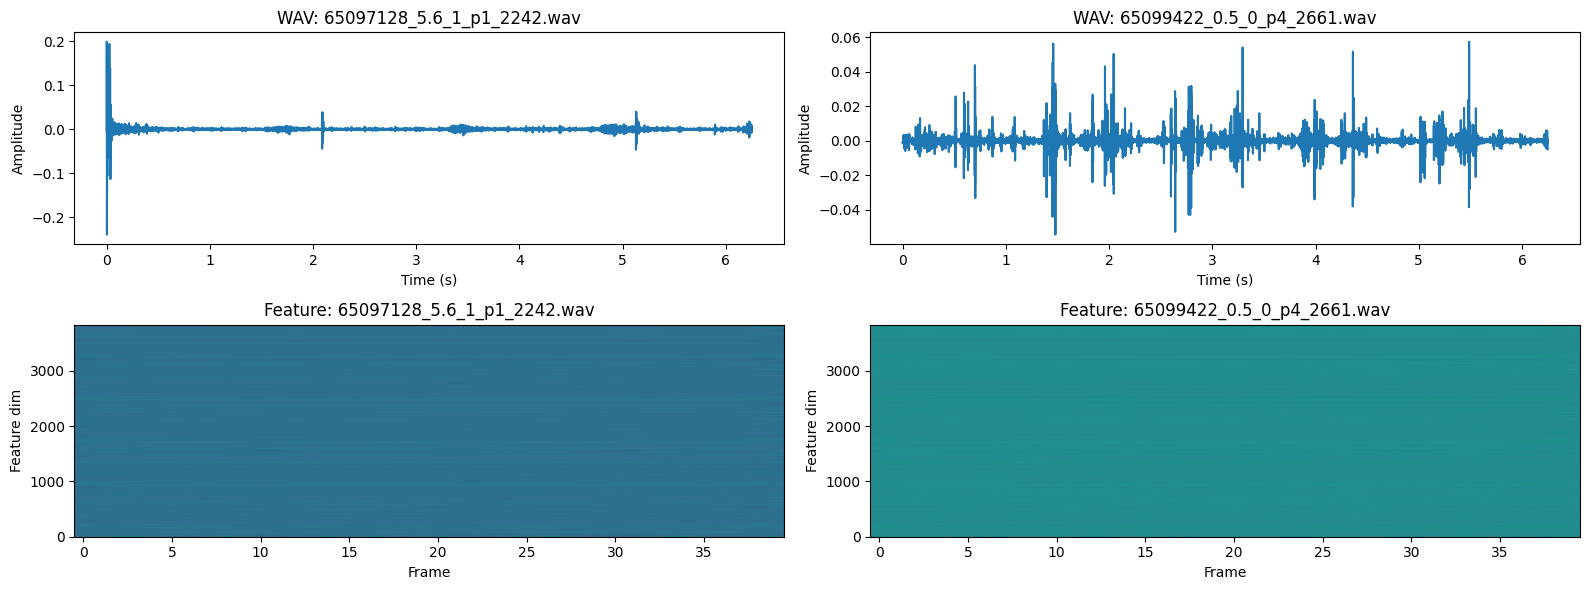

In [10]:

plt.figure(figsize=(16, 6))
for idx, (wav, feat) in enumerate(zip(wavs, features)):
    plt.subplot(2, len(wavs), idx + 1)
    plt.plot(np.arange(len(wav)) / sr, wav)
    plt.title(f"WAV: {sample_files[idx]}")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(2, len(wavs), len(wavs) + idx + 1)
    plt.imshow(feat.numpy().T, aspect='auto', origin='lower')
    plt.title(f"Feature: {sample_files[idx]}")
    plt.xlabel('Frame')
    plt.ylabel('Feature dim')
plt.tight_layout()
plt.show()

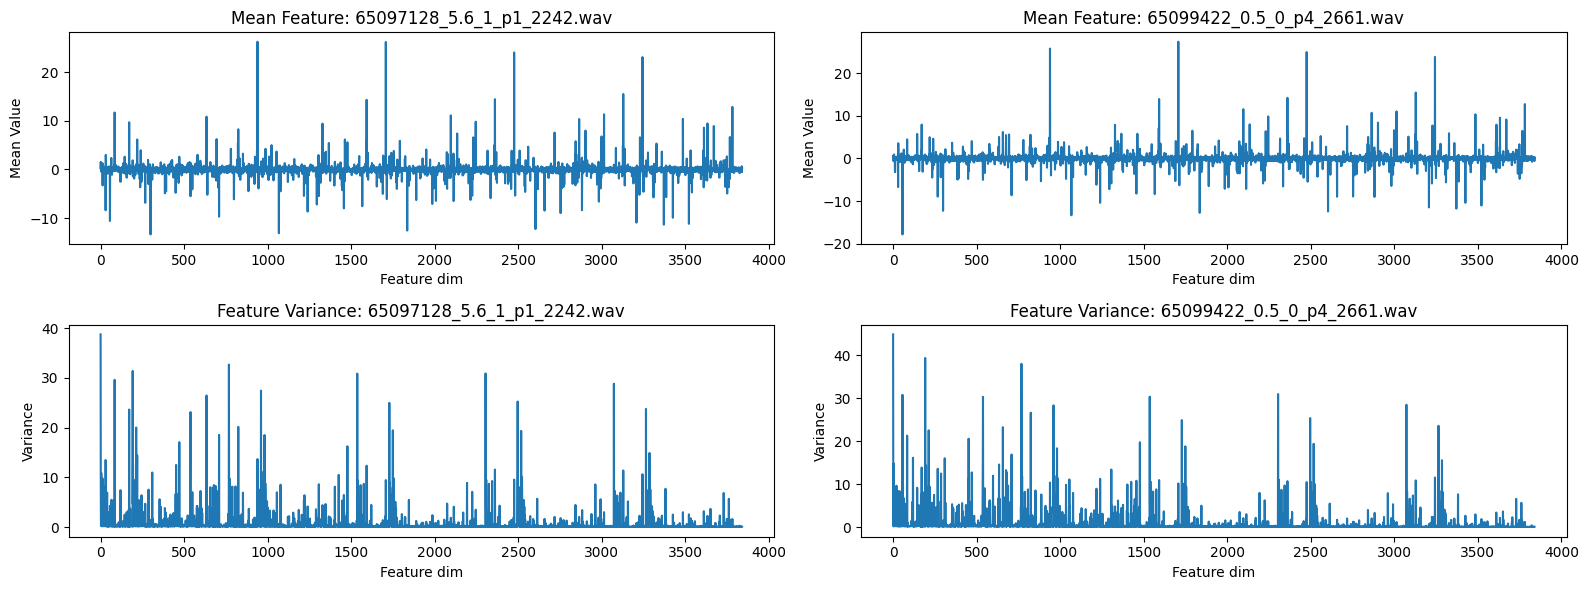

In [11]:
plt.figure(figsize=(16, 6))
for idx, (feat, fname) in enumerate(zip(features, sample_files)):
    mean_feat = feat.numpy().mean(axis=0)
    plt.subplot(2, len(wavs), idx + 1)
    #plt.subplot(len(features), 1, i + 1)
    plt.plot(mean_feat)
    plt.title(f"Mean Feature: {fname}")
    plt.xlabel('Feature dim')
    plt.ylabel('Mean Value')

    var_feat = feat.numpy().var(axis=0)
    plt.subplot(2, len(wavs), len(wavs) + idx + 1)
    plt.plot(var_feat)
    plt.title(f"Feature Variance: {fname}")
    plt.xlabel('Feature dim')
    plt.ylabel('Variance')

plt.tight_layout()
plt.show()

#### Audio clip-level features

To obtain audio clip-level features, we take the average of frame-level features. This produces a 3,840-dimensional vector.

In [12]:
clip_level = features.mean(dim=1)
clip_level.shape

torch.Size([2, 3840])

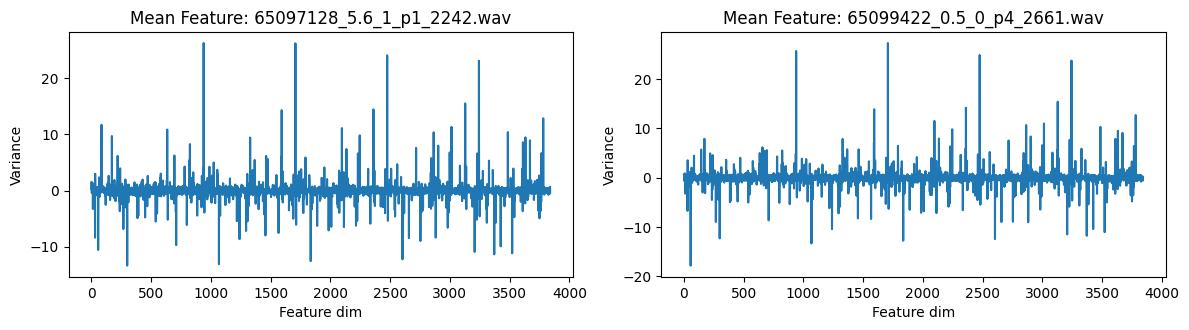

In [13]:
plt.figure(figsize=(12, 6))
for i, (feat, fname) in enumerate(zip(clip_level, sample_files)):
    plt.subplot(len(clip_level), len(clip_level), i + 1)
    plt.plot(feat)
    plt.title(f"Mean Feature: {fname}")
    plt.xlabel('Feature dim')
    plt.ylabel('Variance')
plt.tight_layout()
plt.show()